<a href="https://colab.research.google.com/github/2022Group3/projectNotebooks/blob/main/dirty_label_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# baseline model with dropout and data augmentation on the cifar10 dataset
import numpy as np
import sys
import tensorflow as tf
from matplotlib import pyplot
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load train and test dataset
def load_dataset():
  data=np.load(r'drive/MyDrive/data_modified_new_labels.npz')
  data=dict(zip(("{}".format(k) for k in data),(data[k] for k in data)))
  trainX=data['train']
  trainy=data['ytrain']
  validationX=data['validation']
  validationy=data['yvalidation']
  testX=data['test']
  testy=data['ytest']
  return trainX,trainy,validationX,to_categorical(validationy),testX,to_categorical(testy)

In [4]:
# scale pixels
def prep_pixels(train,validation,test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  validation_norm = validation.astype('float32')
  test_norm=test.astype('float32')
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  validation_norm = validation / 255.0
  # return normalized images
  test_norm=test_norm/255.0
  return train_norm, validation_norm,test_norm

In [5]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

    # list all data in history
    print(history.history.keys())

In [6]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(15, activation='softmax'))
 	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='validation')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')

In [15]:
# # run the test harness for evaluating a model
# def run_test_harness():
# 	# load dataset
#   trainX, trainy,validationX,validationy, testX, testy = load_dataset()
# 	# prepare pixel data
#   trainX, validationX ,testX= prep_pixels(trainX, validationX,testX)
# 	# define model
#   model = define_model()
# 	# create data generator
#   datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# 	# prepare iterator
#   it_train = datagen.flow(trainX, trainy, batch_size=64)
# 	# fit model
#   steps = int(trainX.shape[0] / 64)
#   history = model.fit(it_train, steps_per_epoch=steps, epochs=250, validation_data=(validationX, validationy), verbose=1)
# 	# evaluate model
#   _, acc = model.evaluate(testX, testy, verbose=1)
#   print('> %.3f' % (acc * 100.0))
# 	# learning curves
#   summarize_diagnostics(history)
# 	#save model
#   model.save('/content/drive/MyDrive/new_model.h5')
#   return model

In [10]:

# run the test harness for evaluating a model
def run_test_harness_b():
    # load dataset
    trainX, trainY,validationX, validationY, testX, testY = load_dataset()
  #dirty labels
    percents=10
    len_percents=int(len(trainY)*(percents/100))
    random_indexes=np.random.randint(0,len(trainY),len_percents)
    for i in random_indexes:
      trainY[i]=np.random.randint(0,15)
    trainY=to_categorical(trainY)
    # prepare pixel data
    trainX, validationX, testX = prep_pixels(trainX,validationX, testX)
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    # prepare iterator
    it_train = datagen.flow(trainX, trainY, batch_size=32)
    # fit model
    steps = int(trainX.shape[0] /32)
    history = model.fit(it_train, steps_per_epoch=steps, epochs=250, validation_data=(validationX, validationY), verbose=1)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    # save
    model.save('/content/drive/MyDrive/dirty_label_model.h5')
    return model

Epoch 1/250
1406/1406 [==============================] - 39s 19ms/step - loss: 2.5638 - accuracy: 0.2213 - val_loss: 1.8385 - val_accuracy: 0.3927
Epoch 2/250
1406/1406 [==============================] - 28s 20ms/step - loss: 2.1028 - accuracy: 0.3249 - val_loss: 1.7392 - val_accuracy: 0.4136
Epoch 3/250
1406/1406 [==============================] - 26s 19ms/step - loss: 1.9851 - accuracy: 0.3657 - val_loss: 1.6491 - val_accuracy: 0.4412
Epoch 4/250
1406/1406 [==============================] - 26s 19ms/step - loss: 1.9137 - accuracy: 0.3921 - val_loss: 1.6936 - val_accuracy: 0.4467
Epoch 5/250
1406/1406 [==============================] - 26s 19ms/step - loss: 1.8588 - accuracy: 0.4181 - val_loss: 1.5677 - val_accuracy: 0.4813
Epoch 6/250
1406/1406 [==============================] - 27s 19ms/step - loss: 1.8160 - accuracy: 0.4337 - val_loss: 1.5538 - val_accuracy: 0.4825
Epoch 7/250
1406/1406 [==============================] - 26s 19ms/step - loss: 1.7691 - accuracy: 0.4549 - val_loss: 1

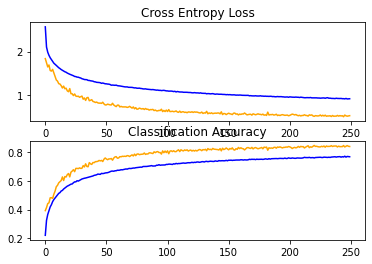

In [11]:
# entry point, run the test harness
model=run_test_harness_b()